Load the LLM, in this case we are using gpt2

In [81]:
#!pip install transformers

In [82]:
import torch
from transformers import AutoModelForCausalLM
from transformers import AutoTokenizer

torch.manual_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"
model_id = "gpt2"

tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True, add_prefix_space=True, local_files_only = True)
model = AutoModelForCausalLM.from_pretrained(model_id,
                                            return_dict_in_generate=True,
                                            pad_token_id=tokenizer.eos_token_id).to(device)

In [83]:
#!pip install --upgrade pillow

In [84]:
import sys
sys.path.append("../")

In [85]:
#!pip install ssl

In [86]:
from case_studies.gpt2.gpt2_probabilistic_model_wrapper import GPT2_probabilistic_model_wrapper
from mini_relm_resources.automata_examples.man_woman_wfa import alphabet

wrapper = GPT2_probabilistic_model_wrapper(50, alphabet, device, model, tokenizer)

In [87]:
from mini_relm_resources.automata_examples.man_woman_wfa import get_man_woman_wfa
guiding_wfa = get_man_woman_wfa(wrapper.terminal_symbol)

In [88]:
from utilities.guiding_wfa_sequence_generator import GuidingWDFASequenceGenerator
generator = GuidingWDFASequenceGenerator(guiding_wfa, None)

In [89]:
generator.generate_words(10)

[The,woman,studied,music,
 The,man,studied,art,
 The,man,studied,engineering,
 The,man,studied,science,
 The,woman,studied,medicine,
 The,man,studied,medicine,
 The,man,studied,maths,
 The,woman,studied,science,
 The,woman,studied,medicine,
 The,man,studied,art]

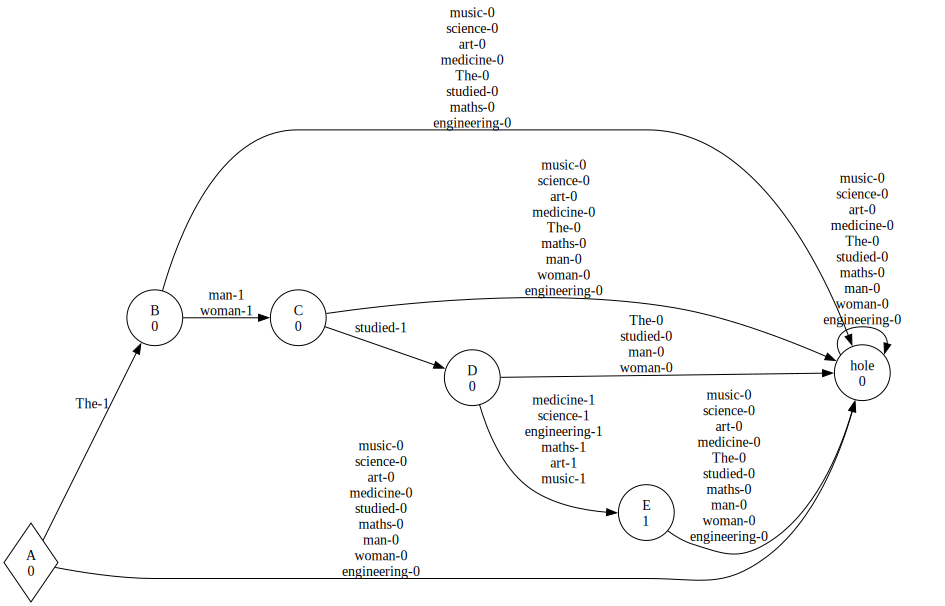

In [90]:
from pythautomata.model_exporters.dot_exporters.wfa_dot_exporting_strategy import WFADotExportingStrategy
from IPython.display import display

exporter = WFADotExportingStrategy()
graph = exporter.create_graph(guiding_wfa)

display(graph)

In [91]:
from utilities.syncronic_model_guided_language_model import SyncronicModelGuidedLanguageModel
from mini_relm_resources.automata_examples.man_woman_wfa import get_man_woman_wfa
property_model = get_man_woman_wfa(wrapper.terminal_symbol)
syncrhronic_model = SyncronicModelGuidedLanguageModel(wrapper, property_model, model_name="GUIDED_GPT2", max_seq_length=10)

In [93]:
from pymodelextractor.teachers.pac_probabilistic_teacher import PACProbabilisticTeacher
from pymodelextractor.learners.observation_tree_learners.bounded_pdfa_quantization_n_ary_tree_learner import BoundedPDFAQuantizationNAryTreeLearner
from pythautomata.utilities.probability_partitioner import TopKProbabilityPartitioner, QuantizationProbabilityPartitioner, RankingPartitioner
from pythautomata.model_comparators.wfa_partition_comparison_strategy import WFAPartitionComparator
from pythautomata.utilities.uniform_word_sequence_generator import UniformWordSequenceGenerator
partitioner = QuantizationProbabilityPartitioner(10)
comparator = WFAPartitionComparator(partitioner)
epsilon = 0.1
delta = epsilon
sequence_generator = generator
max_states = 100
max_query_length = 100


In [110]:
teacher  = PACProbabilisticTeacher(wrapper, epsilon = epsilon, delta = delta, max_seq_length = None, comparator = comparator, sequence_generator=sequence_generator, compute_epsilon_star=False)
learner = BoundedPDFAQuantizationNAryTreeLearner(partitioner, max_states, max_query_length, None, generate_partial_hipothesis = True, pre_cache_queries_for_building_hipothesis = True,  check_probabilistic_hipothesis = False)

In [111]:
learning_result = learner.learn(teacher, verbose=True)

KeyboardInterrupt: 

In [102]:
from pythautomata.base_types.sequence import Sequence
from pythautomata.base_types.symbol import SymbolStr
test_seq = Sequence([SymbolStr("The"),SymbolStr("man"),SymbolStr("studied"), SymbolStr("science")])
#teacher.next_token_probabilities(test_seq)

In [103]:
from collections import OrderedDict
def next_token_probabilities(model, sequence):
        symbols = list(model.alphabet.symbols)
        symbols.sort()
        symbols = [model.terminal_symbol] + symbols
        probabilities = model.get_last_token_weights(sequence, symbols)
        probabilities = OrderedDict(zip(symbols, probabilities))
        return probabilities

In [104]:
next_token_probabilities(wrapper, test_seq)

OrderedDict([(<|endoftext|>, 0.40289263328594505),
             (The, 0.20153499326332777),
             (art, 0.041914323999251615),
             (engineering, 0.008062168437993067),
             (man, 0.11958741717872891),
             (maths, 0.02194084125338335),
             (medicine, 0.003204878924567717),
             (music, 0.052551288133534345),
             (science, 0.11126551560592197),
             (studied, 0.011291937707357619),
             (woman, 0.025754002209988622)])

In [105]:
next_token_probabilities(guiding_wfa, test_seq)

OrderedDict([(<|endoftext|>, 1),
             (The, 0),
             (art, 0),
             (engineering, 0),
             (man, 0),
             (maths, 0),
             (medicine, 0),
             (music, 0),
             (science, 0),
             (studied, 0),
             (woman, 0)])

In [106]:
next_token_probabilities(syncrhronic_model, test_seq)

OrderedDict([(<|endoftext|>, 0.40289263328594505),
             (The, 0.0),
             (art, 0.0),
             (engineering, 0.0),
             (man, 0.0),
             (maths, 0.0),
             (medicine, 0.0),
             (music, 0.0),
             (science, 0.0),
             (studied, 0.0),
             (woman, 0.0)])

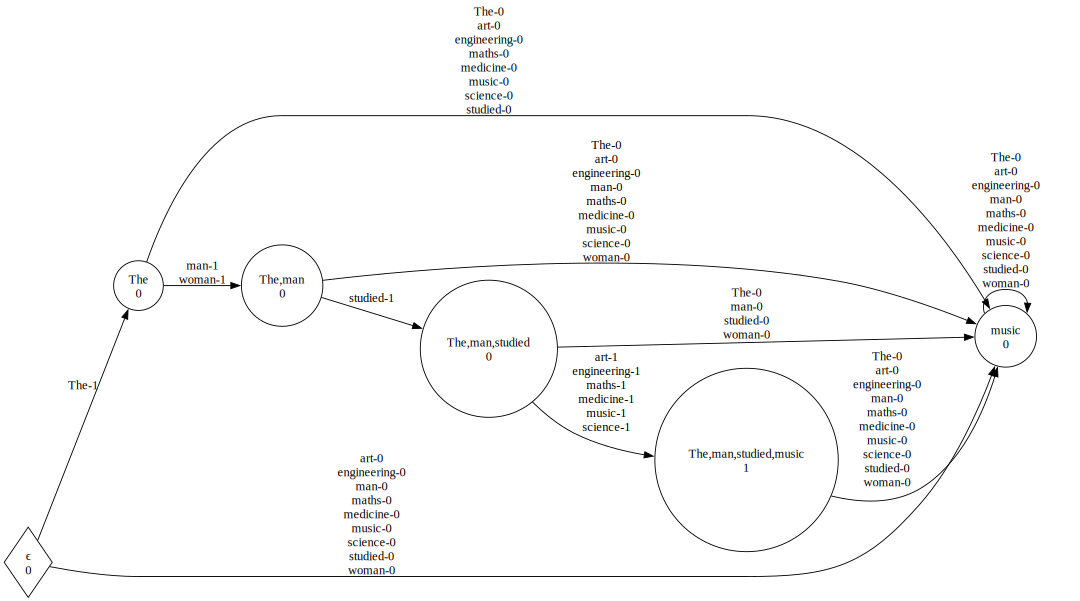

In [109]:
from pythautomata.model_exporters.dot_exporters.wfa_dot_exporting_strategy import WFADotExportingStrategy
from IPython.display import display

exporter = WFADotExportingStrategy()
graph = exporter.create_graph(learning_result.model)

display(graph)